<a href="https://colab.research.google.com/github/o4lc/PINN-CBF/blob/main/F16/F16_Ablations%2BCBF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Fixed-Wing Plane
This 10D system has 7D state and 3D control variables
$$x = [y_1,y_2,y_3, \phi, \theta, \psi, s]^T,\quad u = [a, p, q]^T$$
We describe the control affine system $\dot x = f(x) + g(x)u$ as follows

$$
f(x) = \begin{bmatrix} \textbf{v}(\zeta)\\ \textbf{f}_{\xi}(x)\\0 \end{bmatrix},\quad g(x) =  \begin{bmatrix} 0_{3\times 3}\\ \textbf{g}_{\xi}(x)\\ 1\; 0\;  0\; \end{bmatrix}
$$

$$
\textbf{f}_{\xi}(x)= \frac{g_D}{s}\begin{bmatrix} \sin(\phi)\cos(\phi)\sin(\theta)\\ -(\sin(\phi))^2\cos (\theta)\\ \sin(\phi)\cos(\phi)  \end{bmatrix},\quad
\textbf{g}_{\xi}(x)= \begin{bmatrix} 0 & 1 & \sin(\phi)\tan(\theta)\\ 0 & 0 & \cos (\phi)\\ 0 & 0 & \frac{\sin(\phi)}{\cos(\theta)}  \end{bmatrix}
$$


$$
r =\begin{bmatrix} y_1\\y_2\\y_3 \end{bmatrix},\quad \zeta = \begin{bmatrix} s\\ \theta\\ \psi \end{bmatrix}, \quad \textbf{v}(\zeta) = \begin{bmatrix} s\cos(\theta)\cos(\psi)\\ s\cos(\theta)\sin(\psi) \\ -s\sin(\theta) \end{bmatrix}
$$

$$g_D=\text{ gravitational acceleration}\approx 9.81$$
Recall $$\dot{h}(x) = \nabla h(x)^T\dot{x} = \nabla h(x)^T(f(x) + g(x)u)$$

The following HBJ condition ideally should be enforced at every state
$$\mathcal{L}_{\text{HJB}}(\theta;x)=\min\{c(x)-h_{\theta}(x), \nabla_xh_{\theta}(x)^Tf(x)+\max_u\{\nabla_{x}h_{\theta}(x)^Tg(x)u\}+\gamma h_{\theta}(x)\}\rightarrow0$$
Because $c(x)-h_{\theta}(x)=\delta_{\theta}(x)\geq 0$, there is an implicit nonnegativity constraint on the terms being minimized.
$$\mathcal{L}_{1}(\theta;x)=(\min\{c(x)-h_{\theta}(x), \nabla_xh_{\theta}(x)^Tf(x)+\max_u\{\nabla_{x}h_{\theta}(x)^Tg(x)u\}+\gamma h_{\theta}(x)\})^2\rightarrow 0$$
and
$$\mathcal{L}_{2}(\theta;x)=( -\nabla_xh_{\theta}(x)^Tf(x) - \max_u\{\nabla_{x}h_{\theta}(x)^Tg(x)u\} - \gamma h_{\theta}(x))_{+}\rightarrow 0$$
$$\mathcal{L}_{1}(\theta;x) + \lambda_0 \mathcal{L}_{2}(\theta;x)\rightarrow 0$$
If desired use the following substitution
$$h_{\theta}(x) = (c -\delta_{\theta})(x)$$

Additionally, because the loss should be uniformly 0, its gradient should also be uniformly 0 almost everywhere.

$$\mathcal{L}_{3}(\theta;x)=\|\nabla_x\mathcal{L}_{1}(\theta;x) + \lambda_0 \nabla_x\mathcal{L}_{2}(\theta;x)\|\rightarrow 0$$
$$\mathcal{L}_{1}(\theta;x) + \lambda_0 \mathcal{L}_{2}(\theta;x) + \lambda_1 \mathcal{L}_{3}(\theta;x)\rightarrow 0$$


In [ ]:
!pip install dill
import dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.2 MB/s eta 0:00:00


In [ ]:
import jax
import numpy as onp
import jax.numpy as np
from jax import random, grad, hessian, vmap, jit, config, ops
from jax.nn import sigmoid, relu, elu, softplus, swish, tanh
from jax.example_libraries import optimizers
import jaxlib

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter  # For animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation
import matplotlib.lines as mlines

import cvxpy as cp
import scipy.sparse as sp

import gc

%matplotlib inline


In [ ]:
#For GPU use, check the device before importing anything from torch
jaxlib_version = jaxlib.__version__
print("jaxlib version:", jaxlib_version)
jax_version = jax.__version__
print("JAX version:", jax_version)
print(jax.local_devices())

jaxlib version: 0.4.33
JAX version: 0.4.33
[CpuDevice(id=0)]


In [ ]:
from torch.utils import data
print(jax.local_devices())

[CpuDevice(id=0)]


In [ ]:
# Build custom activation
def custom_softplus(x, beta=1):
    return (1 / beta) * np.log1p(np.exp(beta * x)) #This beta can't be large, causes gradient overflow during training
def custom_tanh(x, beta=1):
    return np.tanh(beta * x)

softplus = partial(custom_softplus, beta=1)
tanh = partial(custom_tanh, beta=1)

In [ ]:
##Hyperparameters

#Model
input_dim = 7
output_dim = 1
layers = [7, 100, 100, 1]
activation = tanh #tanh, elu, custom
output_activation = softplus # softplus, swish, custom

#Cfunc
num_obstacles = 5
beta = 8 #5
sharpness = 8 #1
x_min, x_max, y_min, y_max, z_min, z_max = -5, 5, -5, 5, 0, 10

phi_min, phi_max = -2 * np.pi, 2 * np.pi #Restriction for plotting purposes only
theta_min, theta_max = -2 * np.pi, 2 * np.pi #Restriction for plotting purposes only
psi_min, psi_max = -2 * np.pi, 2 * np.pi #Restriction for plotting purposes only
speed_min, speed_max = 1, 10    #Restriction for plotting purposes only

s_min, s_max = .5, 3 #obstacle size restrictions, used during randomization

#training
P_train = 1000000  # 1M
batch_size = 1000000 # Full batch because memory allows
epochs = 10000

ilr = 1e-3 #larger model and more data necessitates smaller final learning rate
flr = 1e-5
total_steps = epochs * (P_train / batch_size)

decay_rate = .8
if decay_rate < 1 and flr < ilr:
    decay_steps = int(total_steps * np.log(decay_rate) / np.log(flr/ilr))
else:
    decay_steps = 1e9

#u = [a,p,q] these are the max magnitude, this makes the inner maximization simple
a = 10.5
p = 1
q = 1
control_max = np.array([a, p, q])

g_d = 9.81 #Downward gravitational acceleration


#Residuals
gamma = .1

lamb_0 = 1
lamb_1 = 1.5
p = 2

#Validation
P_val = 1000000 # 1M
num_val = 10
# Total val samples = 1M * 10 = 10M
# Due to memory issues compute the validation over 10 equally sized chunks and average. Clear memory between chunks.

In [ ]:
#We only consider obstacles in the spatial coordinates. These will be rectangular without rotation
#[s1, s2, s3, x_c, y_c, z_c]
def generate_obstacles(key, numrect):
    key_side1s, key_side2s, key_side3s, key_center1s, key_center2s, key_center3s = random.split(key, 6)
    s1 = random.uniform(key_side1s, shape=(numrect,), minval=s_min, maxval=s_max)
    s2 = random.uniform(key_side2s, shape=(numrect,), minval=s_min, maxval=s_max)
    s3 = random.uniform(key_side3s, shape=(numrect,), minval=s_min, maxval=s_max)
    xc = random.uniform(key_center1s, shape=(numrect,), minval=x_min, maxval=x_max)
    yc = random.uniform(key_center2s, shape=(numrect,), minval=y_min, maxval=y_max)
    zc = random.uniform(key_center3s, shape=(numrect,), minval=z_min, maxval=z_max)
    obstacles = np.column_stack((s1, s2, s3, xc, yc, zc))

    return obstacles

# Set the seed for reproducibility
key = random.PRNGKey(3)
# Generate shapes
obstacles = generate_obstacles(key, num_obstacles)

print(obstacles)

[[ 2.4310408   0.5634      0.83959985 -2.7140927  -4.965748    3.0102992 ]
 [ 2.272633    2.015176    2.6459553   2.7192688   2.3789132   0.7998383 ]
 [ 1.8110167   2.2451193   0.8462061  -4.4116535   3.0615664   5.5112066 ]
 [ 2.7823331   0.943272    2.9259653   1.9415939   0.313493    6.1720276 ]
 [ 2.135333    2.0035467   1.1468735   4.381621   -3.4133792   2.714206  ]]


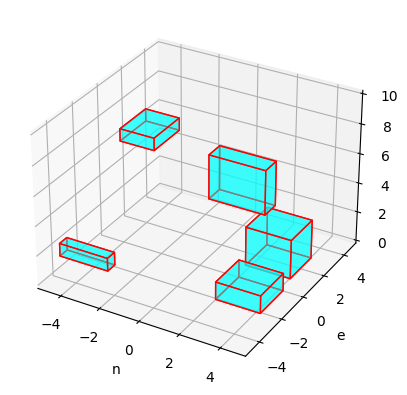

In [ ]:
# Function to plot rectangular obstacles centered on the obstacles
def plot_obstacles_centered(obstacles):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #max_coords = np.max([np.max(np.abs(np.array(obstacle)[:3])) for obstacle in obstacles])

    for obstacle in obstacles:
        s1, s2, s3, xc, yc, zc = obstacle
        vertices = np.array([[xc - s1/2, yc - s2/2, zc - s3/2],
                             [xc + s1/2, yc - s2/2, zc - s3/2],
                             [xc + s1/2, yc + s2/2, zc - s3/2],
                             [xc - s1/2, yc + s2/2, zc - s3/2],
                             [xc - s1/2, yc - s2/2, zc + s3/2],
                             [xc + s1/2, yc - s2/2, zc + s3/2],
                             [xc + s1/2, yc + s2/2, zc + s3/2],
                             [xc - s1/2, yc + s2/2, zc + s3/2]])

        faces = [[vertices[j] for j in [0, 1, 2, 3]],
                 [vertices[j] for j in [4, 5, 6, 7]],
                 [vertices[j] for j in [0, 1, 5, 4]],
                 [vertices[j] for j in [2, 3, 7, 6]],
                 [vertices[j] for j in [0, 3, 7, 4]],
                 [vertices[j] for j in [1, 2, 6, 5]]]

        ax.add_collection3d(Poly3DCollection(faces, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.5))

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    ax.set_xlabel('n')
    ax.set_ylabel('e')
    ax.set_zlabel('d')

    plt.show

plot_obstacles_centered(obstacles)

In [ ]:
#c function
@jit
def obstacle_safety(x, y, z, obstacle):
    s1, s2, s3, xc, yc, zc = obstacle

    # Calculate distances from the edges of the rectangle
    dx_edge = abs(x - xc) - s1 / 2
    dy_edge = abs(y - yc) - s2 / 2
    dz_edge = abs(z - zc) - s3 / 2

    # Calculate the maximum distance outside the obstacle
    max_out = np.max(np.array([dx_edge, dy_edge, dz_edge]))

    return  max_out

@jit
def smooth_obstacle_safety(x, y, z, obstacle, sharpness = sharpness):
    s1, s2, s3, xc, yc, zc = obstacle

    # Calculate distances from the edges of the rectangle
    dx_edge = (np.log(np.exp(sharpness * (x - xc)) + np.exp(sharpness * -(x - xc))) - np.log(2)) / sharpness - s1 / 2
    dy_edge = (np.log(np.exp(sharpness * (y - yc)) + np.exp(sharpness * -(y - yc))) - np.log(2)) / sharpness - s2 / 2
    dz_edge = (np.log(np.exp(sharpness * (z - zc)) + np.exp(sharpness * -(z - zc))) - np.log(2)) / sharpness - s3 / 2

    # Calculate the minimum distance from the boundary
    max_out = (np.log(np.exp(sharpness * dx_edge) + np.exp(sharpness * dy_edge) + np.exp(sharpness * dz_edge)) - np.log(3)) / sharpness #Overuse of sharpness?

    return  max_out

@jit
def cfunc(px, py, pz, obstacles):
    violations = []
    violations.append((px - x_min) * (x_max - px))
    violations.append((py - y_min) * (y_max - py))
    violations.append((pz - z_min) * (z_max - pz))

    for obstacle in obstacles:
        violations.append(obstacle_safety(px, py, pz, obstacle))

    return np.sign(np.min(np.array(violations)))


@jit
def smooth_cfunc(px, py, pz, obstacles, beta=beta):
    sum_exp = np.exp(-beta * np.tanh(px - x_min) * np.tanh(x_max - px)) + np.exp(-beta * np.tanh(py - y_min) * np.tanh(y_max - py)) + np.exp(-beta * np.tanh(pz - z_min) * np.tanh(z_max - pz))

    for obstacle in obstacles:
        sum_exp += np.exp(-beta * np.tanh(smooth_obstacle_safety(px, py, pz, obstacle)))

    log_sum_exp = -np.log(sum_exp) / beta

    return log_sum_exp

#cfunc only takes 3 arguments (x,y,z) while delta takes 7 (x,y,z,phi,theta, psi,s)

In [ ]:
#arbitrary smooth activation van be passed like elu, tanh, silu, softplus, or custom
def MLP(layers, activation=tanh, use_batchnorm=False, init_last_zeros=False, noise_std=1e-8):
    ''' MLP with optional BatchNorm'''
    def init(rng_key):
        def init_layer(key, d_in, d_out, init_zeros=False):
            k1, k2 = random.split(key)
            if init_zeros:
                # W = np.zeros((d_in, d_out))
                # b = np.zeros(d_out)
                W = noise_std * random.normal(k1, (d_in, d_out))
                b = noise_std * random.normal(k2, (d_out,))
            else:
                glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
                W = glorot_stddev * random.normal(k1, (d_in, d_out))
                b = np.zeros(d_out)
            if use_batchnorm:
                # Initialize batchnorm parameters
                scale = np.ones(d_out)
                offset = np.zeros(d_out)
                return W, b, scale, offset
            else:
                return W, b

        key, *keys = random.split(rng_key, len(layers))
        if init_last_zeros:
            params = list(map(init_layer, keys[:-1], layers[:-1], layers[1:], [False]*(len(layers)-1)))
            last_layer_params = init_layer(keys[-1], layers[-2], layers[-1], True)
            params.append(last_layer_params)
        else:
            params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs, is_training=True):
        for layer_params in params[:-1]:
            W, b = layer_params[:2]  # Get weights and biases
            outputs = np.dot(inputs, W) + b
            if use_batchnorm:
                # Extract batchnorm parameters
                scale, offset = layer_params[2:]
                # Compute batch normalization manually
                mean = np.mean(outputs, axis=0)
                variance = np.var(outputs, axis=0)
                normalized_outputs = (outputs - mean) / np.sqrt(variance + 1e-5)
                outputs = scale * normalized_outputs + offset
            outputs = activation(outputs)
            inputs = outputs
        W, b = params[-1][:2]  # Last layer weights and biases
        outputs = np.dot(inputs, W) + b
        return outputs

    return init, apply

In [ ]:
# This functions like a dataloader
# All arguments of the dataloader must have the same number of dims
class DataGenerator(data.Dataset):
    def __init__(self, y, c, gradc, batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.y = y  # Queries (x,y,z,phi,theta, psi,s)
        self.c = c  # Safety function values corresponding to queries
        self.gradc = gradc # for now only first degree

        self.N = y.shape[0]
        self.batch_size = min(batch_size, self.N)  # Ensure batch_size is smaller than N
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        y, c, gradc = self.__data_generation(subkey)
        return y, c, gradc

    def __len__(self):
        'Denotes the total number of samples'
        return self.N

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        y = self.y[idx, :]
        c = self.c[idx, :]
        gradc = self.gradc[idx, :]

        return y, c, gradc

In [ ]:
# Sample training data
def get_gradc(y1, y2, y3, obstacles = obstacles):
    gradc_y1 = grad(smooth_cfunc, argnums=0)(y1, y2, y3, obstacles)
    gradc_y2 = grad(smooth_cfunc, argnums=1)(y1, y2, y3, obstacles)
    gradc_y3 = grad(smooth_cfunc, argnums=2)(y1, y2, y3, obstacles)

    return np.array([gradc_y1, gradc_y2, gradc_y3])

def sample_training_data(key, P=P_train, obstacles=obstacles, sample_outside=True):
    # Generate a batch of random samples
    def generate_samples(key, num_samples):
        key_y1, key_y2, key_y3, key_phi, key_theta, key_psi, key_s = random.split(key, 7)

        y1 = random.uniform(key_y1, (num_samples,), minval=x_min  - (1 - sample_outside), maxval=x_max + (1 - sample_outside))
        y2 = random.uniform(key_y2, (num_samples,), minval=y_min - (1 - sample_outside), maxval=y_max + (1 - sample_outside))
        y3 = random.uniform(key_y3, (num_samples,), minval=z_min - (1 - sample_outside), maxval=z_max + (1 - sample_outside))
        phi = random.uniform(key_phi, (num_samples,), minval=phi_min, maxval=phi_max)
        theta = random.uniform(key_theta, (num_samples,), minval=theta_min, maxval=theta_max)
        psi = random.uniform(key_psi, (num_samples,), minval=psi_min, maxval=psi_max)
        s = random.uniform(key_s, (num_samples,), minval=speed_min, maxval=speed_max)

        return np.column_stack((y1, y2, y3, phi, theta, psi, s)) #multiple samples so use column stack

    # Unified function to compute c values
    def compute_c_values(y_samples):
        c_values_smooth = vmap(smooth_cfunc, (0, 0, 0, None))(y_samples[:, 0], y_samples[:, 1], y_samples[:, 2], obstacles)
        return c_values_smooth

    # Main sampling loop
    y_list = []
    if sample_outside:
        while len(y_list) < P:
            # Generate a batch of samples
            key, subkey = random.split(key)
            batch_size = P - len(y_list) # Adaptive batch size strategy
            y_samples = generate_samples(subkey, batch_size)

            # Compute c values for the entire batch
            c_values = compute_c_values(y_samples)

            # Create a boolean mask for valid samples
            valid_mask = c_values >= 0
            valid_samples = y_samples[valid_mask]

            # Append valid samples to the list
            y_list.extend(valid_samples.tolist())
    else:
         y_samples = generate_samples(key, P)
         y_list.extend(y_samples.tolist())

    # Convert list to array
    y = np.array(y_list)

    # Compute values for c, gradc at sampled points
    c = vmap(smooth_cfunc, (0, 0, 0, None))(y[:, 0], y[:, 1], y[:, 2], obstacles)
    gradc = vmap(get_gradc, (0, 0, 0, None))(y[:, 0], y[:, 1], y[:, 2], obstacles)

    return y, c, gradc

In [ ]:
#F16 affine system f and g
def f_dyn(x, y, z, phi, theta, psi, s):
    v_gamma = np.array([s * np.cos(theta) * np.cos(psi),
                        s * np.cos(theta) * np.sin(psi),
                        -s * np.sin(theta)])
    f_xi = g_d * np.array([np.sin(phi) * np.cos(phi) * np.sin(theta),
                           -(np.sin(phi))**2 * np.cos(theta),
                           np.sin(phi) * np.cos(phi)]) / s

    # Concatenate v_gamma, f_xi, and append a 0
    concatenated_vector = np.concatenate([v_gamma, f_xi, np.array([0])])

    return concatenated_vector

def g_dyn(x, y, z, phi, theta, psi, s):
    g_xi = np.array([[0, 1, np.sin(phi) * np.tan(theta)],
                     [0, 0, np.cos(phi)],
                     [0, 0, np.sin(phi) / np.cos(theta)]])

    concatenated_vector = np.concatenate([np.zeros((3, 3)), g_xi, np.array([[1, 0, 0]])])
    return concatenated_vector

In [ ]:
class PI_MLP:
    def __init__(self, layers, p=p, lamb_0=lamb_0, lamb_1=lamb_1, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros = True):
        # Network initialization and evaluation functions
        self.init, self.apply = MLP(layers, activation=activation, use_batchnorm=use_batchnorm)
        self.p = p
        self.lamb_0 = lamb_0
        self.lamb_1 = lamb_1

        # Optimization parameters
        self.output_activation = output_activation


        # Initialize
        params = self.init(rng_key=random.PRNGKey(1234))

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(optimizers.exponential_decay(ilr, decay_steps=decay_steps, decay_rate=decay_rate))

        # Initialize optimizer state for both phases
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()

        self.nIter = int(P_train / batch_size * epochs)

        # Logger
        self.loss_log = []

    def update_nIter(self, epochs_new):
        self.nIter = int(P_train / batch_size * epochs_new)

    def plot_losses(self):
        # Plotting losses
        plt.figure(figsize=(12, 6))
        plt.plot(self.loss_log, label='Loss', color='blue')

        # Labels and Legends
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        # Show plot
        plt.show()


    def net_diff(self, params, y1, y2, y3, phi, theta, psi, s):
        input_vector = np.hstack([y1, y2, y3, phi, theta, psi, s])
        out = np.squeeze(self.apply(params, input_vector))
        output = softplus(out)

        return output

    def residuals(self, params, y1, y2, y3, phi, theta, psi, s, c, gradc_y1, gradc_y2, gradc_y3, gamma=gamma):
        output = self.net_diff(params, y1, y2, y3, phi, theta, psi, s)
        graddelta = np.array(grad(self.net_diff, argnums=(1, 2, 3, 4, 5, 6, 7))(params, y1, y2, y3, phi, theta, psi, s))
        gradc = np.array([gradc_y1, gradc_y2, gradc_y3, 0, 0, 0, 0])
        f_x = f_dyn(y1, y2, y3, phi, theta, psi, s)
        g_x = g_dyn(y1, y2, y3, phi, theta, psi, s)


        array_1 = np.array([output, np.dot(gradc - graddelta, f_x) + np.dot(np.abs(g_x.T @ (gradc - graddelta)), control_max) + gamma * (np.squeeze(c) - output)]) # Squeeze must be there because c has 2 dims from dataloader
        res_I = np.min(array_1, axis = 0)

        array_2 = np.array([0,  -np.dot(gradc - graddelta, f_x) - np.dot(np.abs(g_x.T @ (gradc - graddelta)), control_max) - gamma * (np.squeeze(c) - output)])
        res_II = np.max(array_2, axis = 0)
        return np.array([res_I, res_II])

    def residual(self, params, y1, y2, y3, phi, theta, psi, s, c, gradc_y1, gradc_y2, gradc_y3):

        two_res = self.residuals(params, y1, y2, y3, phi, theta, psi, s, c, gradc_y1, gradc_y2, gradc_y3)
        return self.lamb_0 * np.abs(two_res[0]) ** self.p + self.lamb_1 * two_res[1] ** self.p


    def loss(self, params, batch):
        # Fetch data
        y, c, gradc = batch
        # Compute forward pass
        pred = vmap(self.residual, (None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))(params, y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4], y[:, 5], y[:, 6], c, gradc[:, 0], gradc[:, 1], gradc[:, 2])
        # Compute loss
        loss = np.mean(pred)
        return loss

    # Define a compiled update step for phase
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gr = grad(self.loss)(params, batch)
        return self.opt_update(i, gr, opt_state)

    # Optimize parameters in two phases
    def train(self, dataset):
        data = iter(dataset)

        pbar = trange(self.nIter)
        # Phase I training loop
        for it in pbar:
            batch = next(data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute and store losses
                loss_value = self.loss(params, batch)
                self.loss_log.append(loss_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value})

In [ ]:
# Validation function
# Unfortunatly uniform samplig nwith shifts will be very difficult and require a 7th power of linear density in order to remain uniform. Instead we will use repeated random sampling with a fixed number of keys
def validation(key, model, P_val=P_val, num_val=num_val, sample_outside=True, gamma=gamma):
    # Initialize metrics
    avg_abs_res_I = 0
    avg_safety = 0
    rel_vol = 0

    for i in range(num_val):
        key, subkey = random.split(key)
        y_val, c_val, gradc_val = sample_training_data(subkey, P=P_val, sample_outside=sample_outside)

        ndata = y_val.shape[0]
        params = model.get_params(model.opt_state)

        res_both = vmap(model.residuals, (None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))(params, y_val[:, 0], y_val[:, 1], y_val[:, 2], y_val[:, 3], y_val[:, 4], y_val[:, 5], y_val[:, 6], c_val, gradc_val[:, 0], gradc_val[:, 1], gradc_val[:, 2])

        res_I = res_both[:,0]
        res_II = res_both[:,1]
        abs_res_I = np.abs(res_I)

        delta_val = vmap(model.net_diff, (None, 0, 0, 0, 0, 0, 0, 0))(params, y_val[:, 0], y_val[:, 1], y_val[:, 2], y_val[:, 3], y_val[:, 4], y_val[:, 5], y_val[:, 6])
        h_val = c_val - delta_val

        # Compute other metrics
        avg_abs_res_I += np.mean(abs_res_I)
        avg_safety += np.mean(res_II)

        # Compute relative volume
        rel_vol += np.mean(h_val >= 0)

        # Delete large variables to free up memory
        del y_val, c_val, gradc_val, res_both, res_I, res_II, abs_res_I, delta_val, h_val
        gc.collect()  # Optional: trigger garbage collection

    # Print the calculated values
    print(f"Average of abs_res_I: {avg_abs_res_I / num_val}")
    print(f"Average of safety: {avg_safety / num_val}")
    print(f"Relative volume: {rel_vol / num_val}")

##Train

In [ ]:
key_outside = random.PRNGKey(0) # use different key for generating test data
key_full = random.PRNGKey(1)

y_train_outside, c_train_outside, gradc_train_outside = sample_training_data(key_outside)
y_train_full, c_train_full, gradc_train_full = sample_training_data(key_full)

In [ ]:
print(y_train_outside.shape)
print(c_train_outside.shape)
print(gradc_train_outside.shape)
print(y_train_full.shape)
print(c_train_full.shape)
print(gradc_train_full.shape)

(1000000, 7)
(1000000,)
(1000000, 3)
(1000000, 7)
(1000000,)
(1000000, 3)


In [ ]:
# Create data set
training_dataset_outside  = DataGenerator(y_train_outside, np.expand_dims(c_train_outside, axis=1), gradc_train_outside, batch_size = batch_size)
training_dataset_full  = DataGenerator(y_train_full,  np.expand_dims(c_train_full, axis=1), gradc_train_full, batch_size = batch_size)

In [ ]:
#Initalize models
F16_HJ = PI_MLP(layers, lamb_0=1, lamb_1=0, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)
F16_HJ_IS = PI_MLP(layers, lamb_0=1, lamb_1=0, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)

F16_HJ_CBF05 = PI_MLP(layers, lamb_0=1, lamb_1=0.5, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)
F16_HJ_CBF1 = PI_MLP(layers, lamb_0=1, lamb_1=1, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)

F16_HJ_CBF05_IS = PI_MLP(layers, lamb_0=1, lamb_1=0.5, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)
F16_HJ_CBF1_IS = PI_MLP(layers, lamb_0=1, lamb_1=1, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)

F16_CBF = PI_MLP(layers, lamb_0=0, lamb_1=1, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)

100%|██████████| 10000/10000 [25:33<00:00,  6.52it/s, Loss=0.24919343]


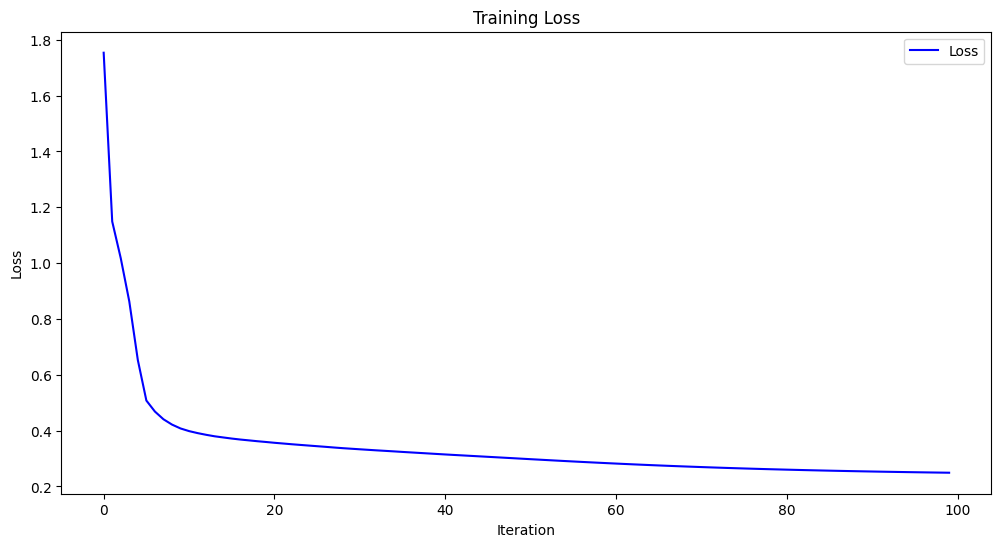

100%|██████████| 10000/10000 [25:17<00:00,  6.59it/s, Loss=0.24358971]


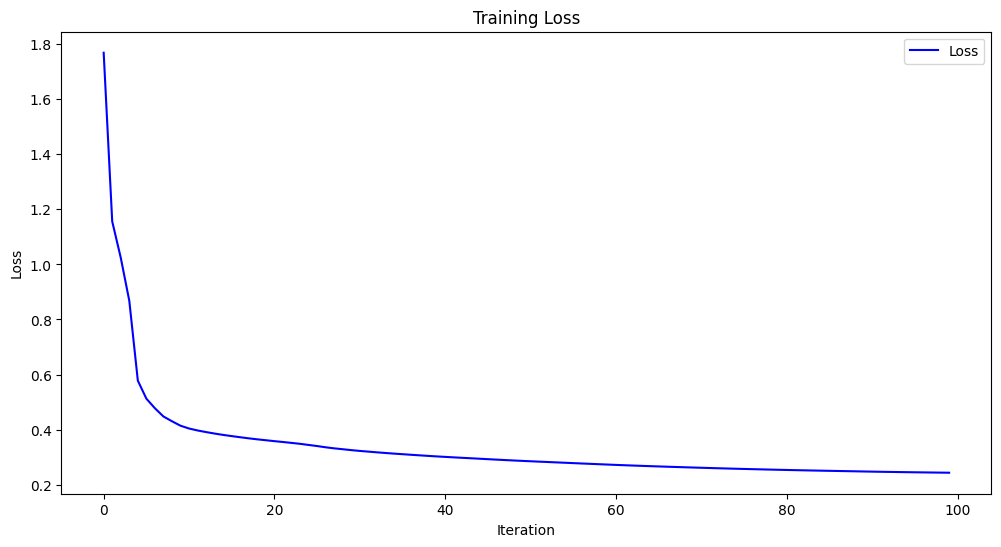

100%|██████████| 10000/10000 [26:35<00:00,  6.27it/s, Loss=0.19441293]


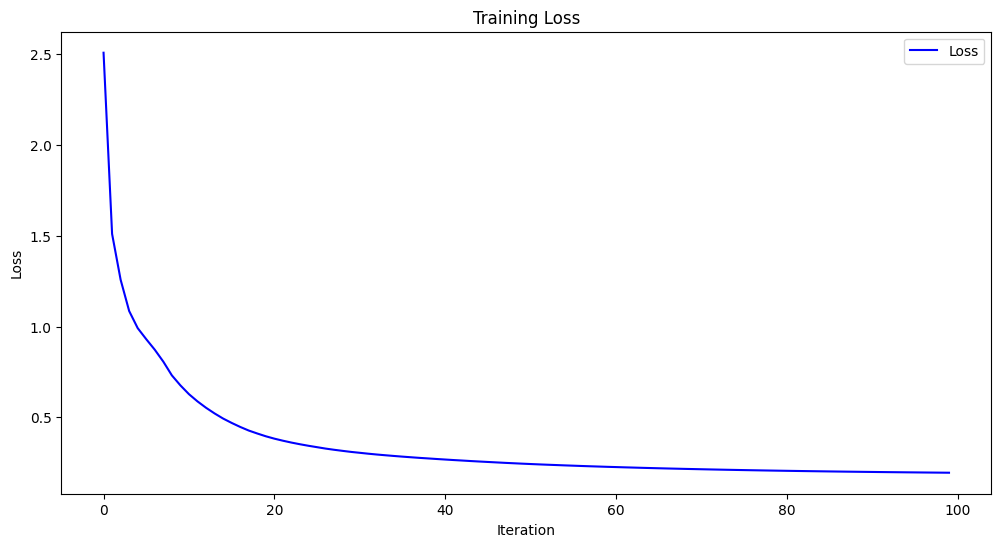

100%|██████████| 10000/10000 [26:38<00:00,  6.26it/s, Loss=0.1691589]


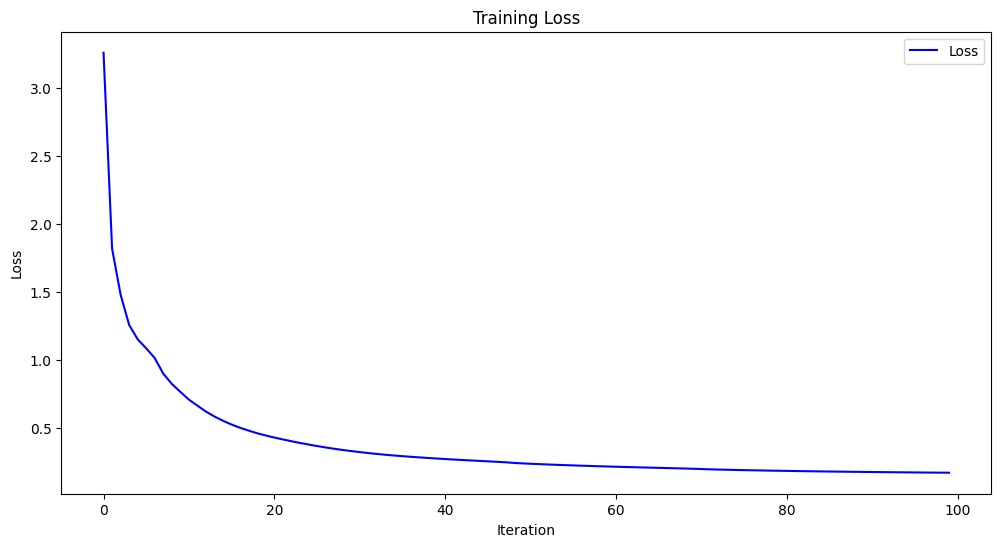

100%|██████████| 10000/10000 [26:41<00:00,  6.25it/s, Loss=0.14877371]


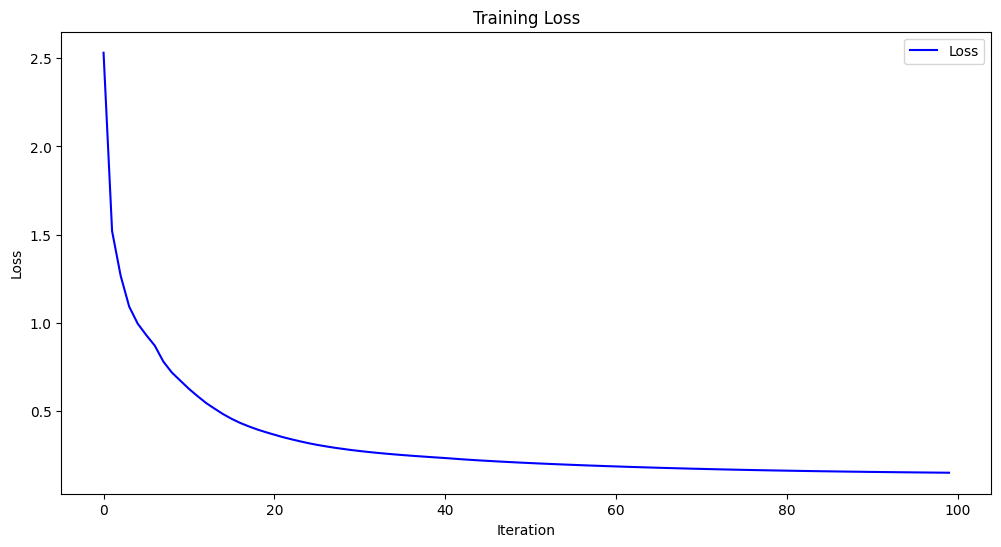

100%|██████████| 10000/10000 [26:37<00:00,  6.26it/s, Loss=0.17526124]


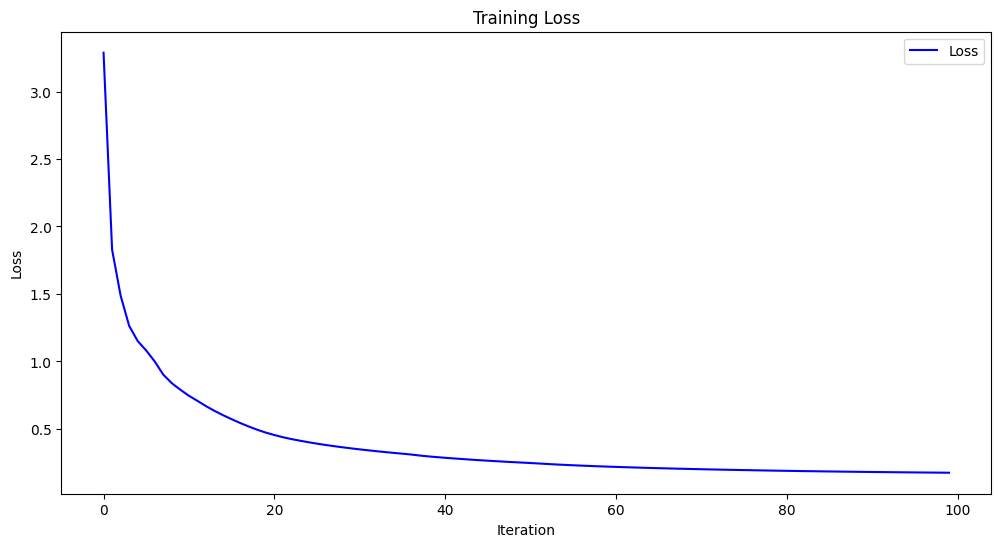

100%|██████████| 10000/10000 [24:05<00:00,  6.92it/s, Loss=3.084293e-06]


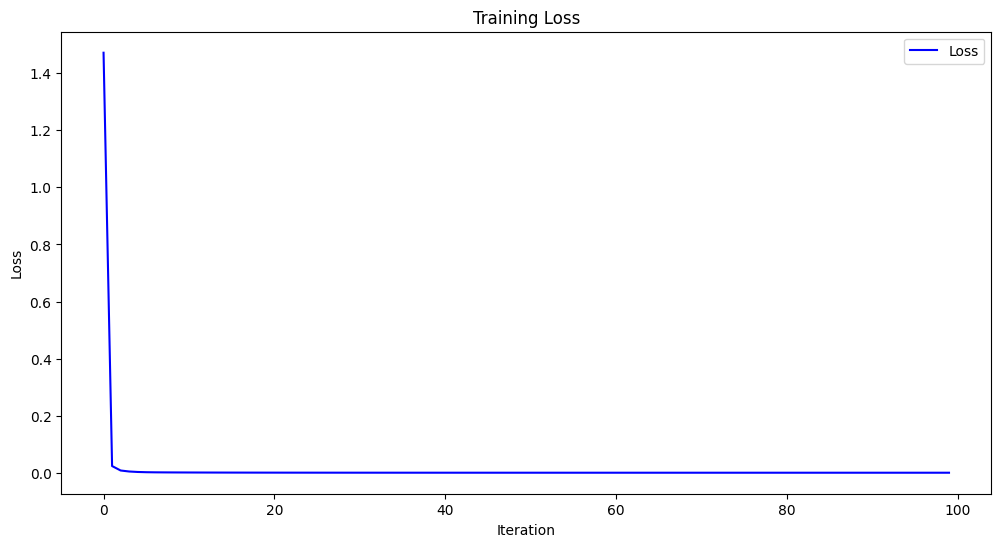

In [ ]:
# Train
F16_HJ.train(training_dataset_full)
F16_HJ.plot_losses()
F16_HJ_IS.train(training_dataset_outside)
F16_HJ_IS.plot_losses()

F16_HJ_CBF05.train(training_dataset_full)
F16_HJ_CBF05.plot_losses()
F16_HJ_CBF1.train(training_dataset_full)
F16_HJ_CBF1.plot_losses()

F16_HJ_CBF05_IS.train(training_dataset_outside)
F16_HJ_CBF05_IS.plot_losses()
F16_HJ_CBF1_IS.train(training_dataset_outside)
F16_HJ_CBF1_IS.plot_losses()

F16_CBF.train(training_dataset_full)
F16_CBF.plot_losses()

In [ ]:
F16_HJ_CBF01 = PI_MLP(layers, lamb_0=1, lamb_1=0.1, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)
F16_HJ_CBF01_IS = PI_MLP(layers, lamb_0=1, lamb_1=0.1, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)

F16_HJ_CBF02 = PI_MLP(layers, lamb_0=1, lamb_1=0.2, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)
F16_HJ_CBF02_IS = PI_MLP(layers, lamb_0=1, lamb_1=0.2, p=p, activation=tanh, output_activation=softplus, use_batchnorm=False, init_last_zeros=True)

100%|██████████| 10000/10000 [25:16<00:00,  6.59it/s, Loss=0.25210088]


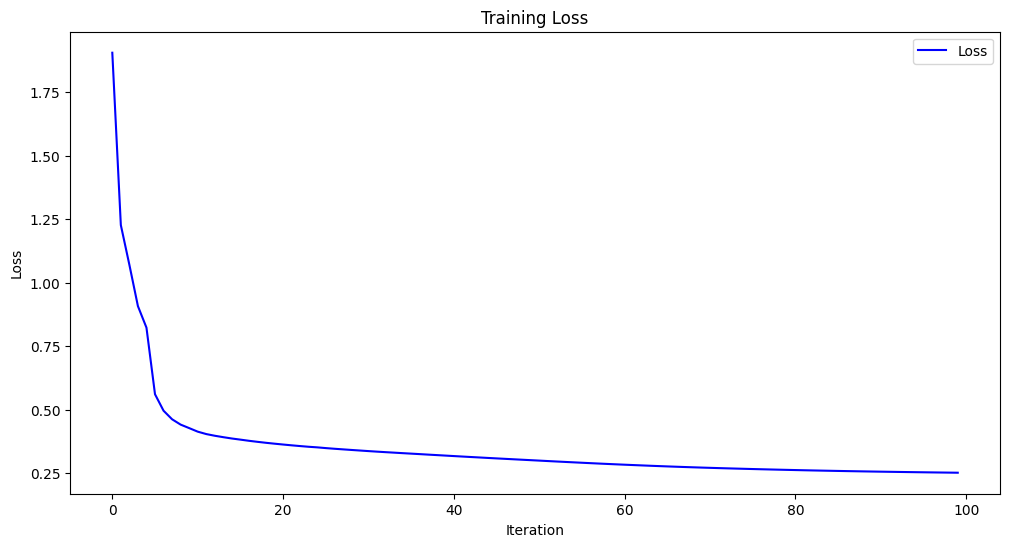

100%|██████████| 10000/10000 [25:16<00:00,  6.60it/s, Loss=0.24287038]


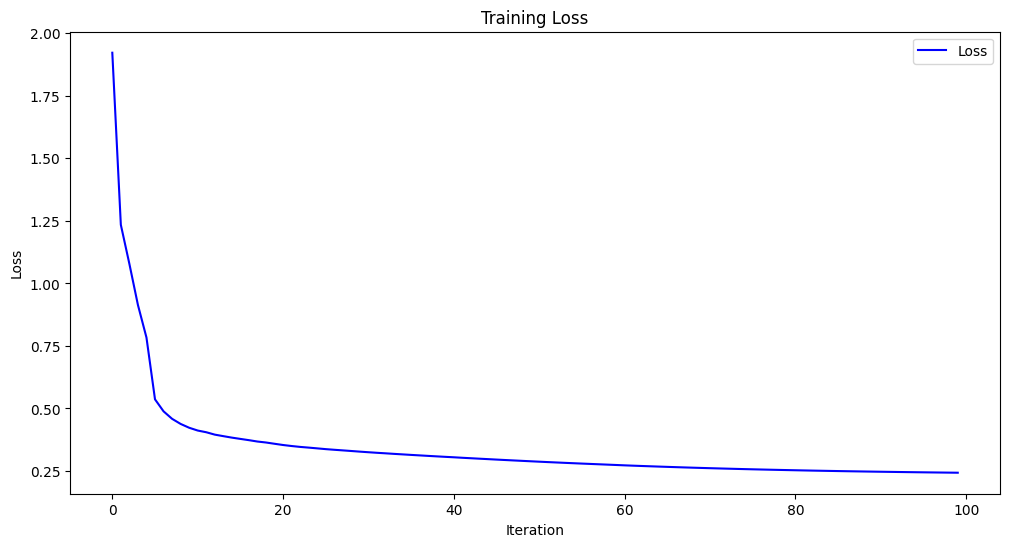

100%|██████████| 10000/10000 [25:14<00:00,  6.60it/s, Loss=0.25913167]


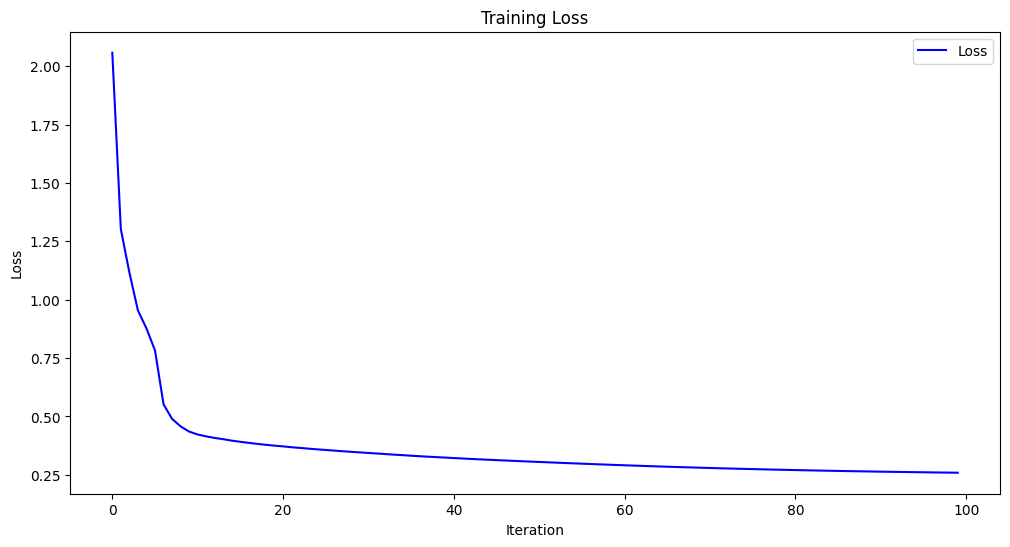

100%|██████████| 10000/10000 [25:15<00:00,  6.60it/s, Loss=0.25725552]


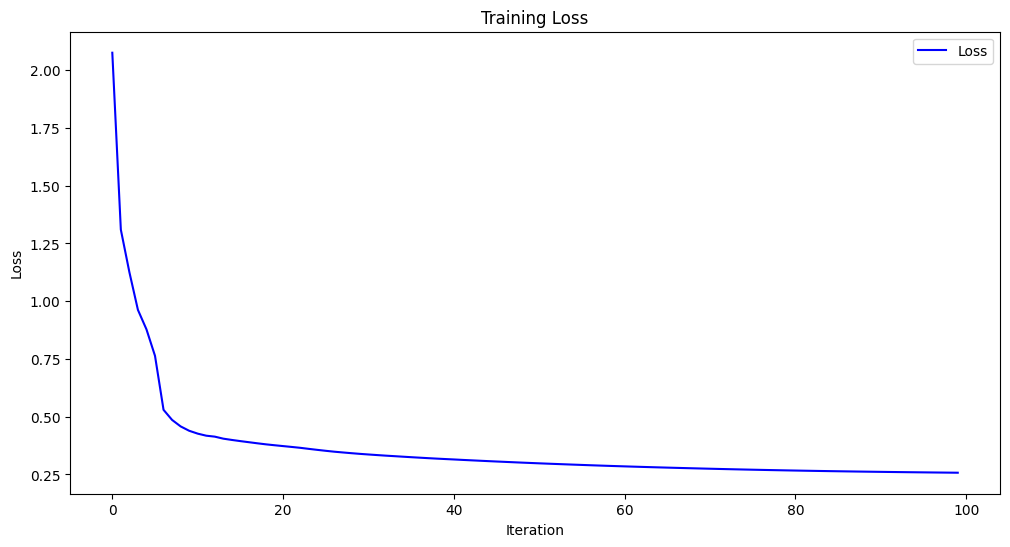

In [ ]:
F16_HJ_CBF01.train(training_dataset_full)
F16_HJ_CBF01.plot_losses()
F16_HJ_CBF01_IS.train(training_dataset_outside)
F16_HJ_CBF01_IS.plot_losses()

F16_HJ_CBF02.train(training_dataset_full)
F16_HJ_CBF02.plot_losses()
F16_HJ_CBF02_IS.train(training_dataset_outside)
F16_HJ_CBF02_IS.plot_losses()

In [ ]:
with open('F16_HJ_CBF01.pkl', 'wb') as f:
    dill.dump(F16_HJ_CBF01, f)
with open('F16_HJ_CBF01_IS.pkl', 'wb') as f:
    dill.dump(F16_HJ_CBF01_IS, f)
with open('F16_HJ_CBF02.pkl', 'wb') as f:
    dill.dump(F16_HJ_CBF02, f)
with open('F16_HJ_CBF02_IS.pkl', 'wb') as f:
    dill.dump(F16_HJ_CBF02_IS, f)

In [ ]:
# Save Models
with open('F16_HJ.pkl', 'wb') as f:
    dill.dump(F16_HJ, f)
with open('F16_HJ_IS.pkl', 'wb') as f:
    dill.dump(F16_HJ_IS, f)

with open('F16_HJ_CBF05.pkl', 'wb') as f:
    dill.dump(F16_HJ_CBF05, f)
with open('F16_HJ_CBF1.pkl', 'wb') as f:
    dill.dump(F16_HJ_CBF1, f)

with open('F16_HJ_CBF05_IS.pkl', 'wb') as f:
    dill.dump(F16_HJ_CBF05_IS, f)
with open('F16_HJ_CBF1_IS.pkl', 'wb') as f:
    dill.dump(F16_HJ_CBF1_IS, f)

with open('F16_CBF.pkl', 'wb') as f:
    dill.dump(F16_CBF, f)

In [ ]:
# Validation
models = {
    "F16_HJ": F16_HJ,
    "F16_HJ_IS": F16_HJ_IS,
    "F16_HJ_CBF05": F16_HJ_CBF05,
    "F16_HJ_CBF1": F16_HJ_CBF1,
    "F16_HJ_CBF05_IS": F16_HJ_CBF05_IS,
    "F16_HJ_CBF1_IS": F16_HJ_CBF1_IS,
    "F16_CBF": F16_CBF
}
key = random.PRNGKey(42)

for model_name, model in models.items():
    print(f"Validating model: {model_name}")
    validation(key, model, P_val=P_val, num_val=num_val, sample_outside=True, gamma=gamma)

Validating model: F16_HJ
Average of abs_res_I: 0.3448823094367981
Average of safety: 0.08816152811050415
Relative volume: 0.7070924639701843
Validating model: F16_HJ_IS
Average of abs_res_I: 0.33914050459861755
Average of safety: 0.08767291158437729
Relative volume: 0.7081671357154846
Validating model: F16_HJ_CBF05
Average of abs_res_I: 0.28584152460098267
Average of safety: 0.07492434233427048
Relative volume: 0.03157529979944229
Validating model: F16_HJ_CBF1
Average of abs_res_I: 0.2418561428785324
Average of safety: 0.06580052524805069
Relative volume: 0.0003436000260990113
Validating model: F16_HJ_CBF05_IS
Average of abs_res_I: 0.234693244099617
Average of safety: 0.0768289789557457
Relative volume: 0.0007603000267408788
Validating model: F16_HJ_CBF1_IS
Average of abs_res_I: 0.24989016354084015
Average of safety: 0.06604807078838348
Relative volume: 0.0015645999228581786
Validating model: F16_CBF
Average of abs_res_I: 5.793715000152588
Average of safety: 0.000273076439043507
Relati

In [ ]:
models = {
    "F16_HJ_CBF01": F16_HJ_CBF01,
    "F16_HJ_CBF01_IS": F16_HJ_CBF01_IS,
    "F16_HJ_CBF02": F16_HJ_CBF02,
    "F16_HJ_CBF02_IS": F16_HJ_CBF02_IS,
}
key = random.PRNGKey(42)

for model_name, model in models.items():
    print(f"Validating model: {model_name}")
    validation(key, model, P_val=P_val, num_val=num_val, sample_outside=True, gamma=gamma)

Validating model: F16_HJ_CBF01
Average of abs_res_I: 0.3446825444698334
Average of safety: 0.0816662535071373
Relative volume: 0.7023628950119019
Validating model: F16_HJ_CBF01_IS
Average of abs_res_I: 0.33858439326286316
Average of safety: 0.08106617629528046
Relative volume: 0.6995450854301453
Validating model: F16_HJ_CBF02
Average of abs_res_I: 0.3470418155193329
Average of safety: 0.07799091935157776
Relative volume: 0.6920241713523865
Validating model: F16_HJ_CBF02_IS
Average of abs_res_I: 0.345721572637558
Average of safety: 0.07805611938238144
Relative volume: 0.6912210583686829


##Filtered Trajectory

The controller perfoms velocity matching not position matching. Test trajectories will focus on avoiding obstacles rather than hitting targets.

Place obstacles in the way of velocity and run for some number of time steps

In [ ]:
def euler_to_rotation_matrix(phi, theta, psi):
    R_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])

    R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                    [0, 1, 0],
                    [-np.sin(theta), 0, np.cos(theta)]])

    R_x = np.array([[1, 0, 0],
                    [0, np.cos(phi), -np.sin(phi)],
                    [0, np.sin(phi), np.cos(phi)]])

    return np.dot(R_z, np.dot(R_y, R_x))

In [ ]:
class F16_Controller:
    def __init__(self, initial_state, dt, filter = None, alpha = .05):
        #Controller parameters
        self.initial_state = initial_state
        self.dt = dt  # Time step
        self.alpha = alpha
        self.filter = filter
        if self.filter != None:
            self.filter_params = self.filter.get_params(self.filter.opt_state)


    def f_dynamics(self, x, y, z, phi, theta, psi, s):
        v_gamma = np.array([s * np.cos(theta) * np.cos(psi),
                            s * np.cos(theta) * np.sin(psi),
                            -s * np.sin(theta)])
        f_xi = g_d * np.array([np.sin(phi) * np.cos(phi) * np.sin(theta),
                            -(np.sin(phi))**2 * np.cos(theta),
                            np.sin(phi) * np.cos(phi)]) / s

        # Concatenate v_gamma, f_xi, and append a 0
        concatenated_vector = np.concatenate([v_gamma, f_xi, np.array([0])])

        return concatenated_vector

    def g_dynamics(self, x, y, z, phi, theta, psi, s):
        g_xi = np.array([[0, 1, np.sin(phi) * np.tan(theta)],
                        [0, 0, np.cos(phi)],
                        [0, 0, np.sin(phi) / np.cos(theta)]])

        concatenated_vector = np.concatenate([np.zeros((3, 3)), g_xi, np.array([[1, 0, 0]])])
        return concatenated_vector


    def safety_correction(self, state, u):
        # Define decision variable
        if self.filter == None:
            u = np.clip(u, -control_max, control_max)

            return u
        else:
            #Evaluate the output for an enviornment and state
            delta = self.filter.net_diff(self.filter_params, state[0], state[1], state[2], state[3], state[4], state[5], state[6])
            graddelta = np.array(grad(self.filter.net_diff, argnums=(1, 2, 3, 4, 5, 6, 7))(self.filter_params, state[0], state[1], state[2], state[3], state[4], state[5], state[6]))

            gradc = get_gradc(state[0], state[1], state[2], obstacles)
            c = smooth_cfunc(state[0], state[1], state[2], obstacles)

            #compute h and gradh
            h = c - delta

            #print(h)
            padded_gradc = np.pad(gradc, (0, graddelta.shape[0] - gradc.shape[0]))
            gradh =  padded_gradc - graddelta

            f_t = self.f_dynamics(state[0], state[1], state[2], state[3], state[4], state[5], state[6])
            g_t = self.g_dynamics(state[0], state[1], state[2], state[3], state[4], state[5], state[6])

            a = self.alpha
            signh = np.sign(h)
            max_it = 10
            it = 0

            u_var = cp.Variable(shape=(3,))

            while np.any(u_var.value is None) and it < max_it:
                it += 1
                a = a * 1.5 **(signh * it)
                #Quadratic program
                u_var = cp.Variable(shape=(3,))
                u_ref = u

                # Objective
                objective = cp.Minimize(cp.sum_squares(u_var - u_ref))


                # Define constraints
                constraints = [gradh.T @ (f_t + g_t @ u_var) + a * h >= 0,
                                u_var <= control_max,
                                u_var >= -control_max]

                # Formulate the optimization problem
                problem = cp.Problem(objective, constraints)

                # Solve the problem
                problem.solve()
            return u_var.value if problem.status == 'optimal' else None

    def control_policy(self, t):
        A_t = a * t / 8 + 1
        p_t =  p * np.sin(2*t)/4
        q_t = q * np.cos(1*t)/5
        return np.array([A_t, p_t, q_t])

    def control(self, state, t):
        u = self.control_policy(t)
        u = self.safety_correction(state, u)
        return u

    def update_state(self, state, t):
        u_t = self.control(state, t)
        f_t = self.f_dynamics(state[0], state[1], state[2], state[3], state[4], state[5], state[6])
        g_t = self.g_dynamics(state[0], state[1], state[2], state[3], state[4], state[5], state[6])
        return state + self.dt * (f_t + g_t @ u_t)

    def calculate_trajectory(self, T):
        state_trajectory = [self.initial_state]
        t = 0

        while t <= T:
            state = self.update_state(state_trajectory[-1], t)
            state_trajectory.append(state)
            t += self.dt

        return state_trajectory

    def plot_trajectories(self, trajectories_list, trajectory_names=None, colors_list=None):
        fig = plt.figure(figsize=(18, 6))

        # Define view angles
        view_angles = [(30, 30), (60, 30), (120, 30), (150, 30)]
        titles = ['View 1: 30° Azimuth, 30° Elevation', 'View 2: 90° Azimuth, 0° Elevation',
                'View 3: 0° Azimuth, 90° Elevation', 'View 4: 60° Azimuth, 70° Elevation']

        # If no custom color list is provided, use a default colormap
        if colors_list is None:
            colors = plt.cm.viridis(np.linspace(0, 1, len(trajectories_list)))
        else:
            assert len(colors_list) == len(trajectories_list), "Length of colors_list must match the number of trajectories."
            colors = colors_list

        for i, (azim, elev) in enumerate(view_angles):
            ax = fig.add_subplot(1, 4, i + 1, projection='3d')

            # Plot obstacles
            for obstacle in obstacles:
                s1, s2, s3, xc, yc, zc = obstacle
                vertices = np.array([[xc - s1 / 2, yc - s2 / 2, zc - s3 / 2],
                                    [xc + s1 / 2, yc - s2 / 2, zc - s3 / 2],
                                    [xc + s1 / 2, yc + s2 / 2, zc - s3 / 2],
                                    [xc - s1 / 2, yc + s2 / 2, zc - s3 / 2],
                                    [xc - s1 / 2, yc - s2 / 2, zc + s3 / 2],
                                    [xc + s1 / 2, yc - s2 / 2, zc + s3 / 2],
                                    [xc + s1 / 2, yc + s2 / 2, zc + s3 / 2],
                                    [xc - s1 / 2, yc + s2 / 2, zc + s3 / 2]])

                faces = [[vertices[j] for j in [0, 1, 2, 3]],
                        [vertices[j] for j in [4, 5, 6, 7]],
                        [vertices[j] for j in [0, 1, 5, 4]],
                        [vertices[j] for j in [2, 3, 7, 6]],
                        [vertices[j] for j in [0, 3, 7, 4]],
                        [vertices[j] for j in [1, 2, 6, 5]]]

                ax.add_collection3d(Poly3DCollection(faces, facecolors='black', linewidths=1, edgecolors='white', alpha=.5))

            # Plot trajectories
            for idx, state_trajectory in enumerate(trajectories_list):
                positions = np.array(state_trajectory)[:, 0:3]
                phis = np.array(state_trajectory)[:, 3]
                thetas = np.array(state_trajectory)[:, 4]
                psis = np.array(state_trajectory)[:, 5]
                speeds = np.array(state_trajectory)[:, 6]

                velocity_vectors = []
                for j in range(len(state_trajectory)):
                    velocity_vector = np.array([np.cos(thetas[j]) * np.cos(psis[j]),
                                                np.cos(thetas[j]) * np.sin(psis[j]),
                                                -np.sin(thetas[j])])
                    velocity_vectors.append(velocity_vector)

                velocity_vectors = np.array(velocity_vectors)
                x = positions[:, 0]
                y = positions[:, 1]
                z = positions[:, 2]

                # Plot smaller quivers for velocity vectors with custom colors
                for j in range(0, len(positions), 2):
                    ax.quiver(positions[j, 0], positions[j, 1], positions[j, 2],
                            velocity_vectors[j, 0], velocity_vectors[j, 1], velocity_vectors[j, 2],
                            color=colors[idx], length=1.5, normalize=True)

                initial_position = positions[0]
                final_position = positions[-1]
                ax.scatter(initial_position[0], initial_position[1], initial_position[2], color='black', s=50, alpha=1, label='Initial Position')  # Fully opaque
                ax.scatter(final_position[0], final_position[1], final_position[2], color='black', s=50, alpha=1, label='Final Position')  # Fully opaque

                # Removed scatter for hvals

                # Add any additional logic or plots if needed

            ax.set_xlim(x_min + 1, x_max - 1)
            ax.set_ylim(y_min + 1, y_max - 1)
            ax.set_zlim(z_min + 1, z_max - 1)

            ax.set_xlabel('X', fontsize=16)
            ax.set_ylabel('Y', fontsize=16)
            ax.set_zlabel('Z', fontsize=16)
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.tick_params(axis='both', which='minor', labelsize=12)

            ax.view_init(elev, azim)

        # Create a custom legend with trajectory names
        if trajectory_names is not None:
            handles = []
            for idx, name in enumerate(trajectory_names):
                line = mlines.Line2D([], [], color=colors[idx], marker='o', linestyle='None', markersize=10, label=name)
                handles.append(line)
            plt.legend(handles=handles, loc='upper right', fontsize=12)

        plt.tight_layout()
        plt.show()

    #Plot the heatmap of the CBF first and its zero level set. Then Plot the trajectory in between with a blue dashed line and blue start points. Plot the box with a black dashed line
    # def plot_trajectories(self, trajectories_list, trajectory_names=None, colors_list=None):
    #     fig = plt.figure(figsize=(18, 6))

    #     # Define view angles
    #     view_angles = [(30, 30), (60, 30), (120, 30), (150, 30)]
    #     titles = ['View 1: 30° Azimuth, 30° Elevation', 'View 2: 90° Azimuth, 0° Elevation',
    #             'View 3: 0° Azimuth, 90° Elevation', 'View 4: 60° Azimuth, 70° Elevation']

    #     # If no custom color list is provided, use a default colormap
    #     if colors_list is None:
    #         colors = plt.cm.viridis(np.linspace(0, 1, len(trajectories_list)))
    #     else:
    #         assert len(colors_list) == len(trajectories_list), "Length of colors_list must match the number of trajectories."
    #         colors = colors_list

    #     for i, (azim, elev) in enumerate(view_angles):
    #         ax = fig.add_subplot(1, 4, i + 1, projection='3d')

    #         # Plot obstacles
    #         for obstacle in obstacles:
    #             s1, s2, s3, xc, yc, zc = obstacle
    #             vertices = np.array([[xc - s1 / 2, yc - s2 / 2, zc - s3 / 2],
    #                                 [xc + s1 / 2, yc - s2 / 2, zc - s3 / 2],
    #                                 [xc + s1 / 2, yc + s2 / 2, zc - s3 / 2],
    #                                 [xc - s1 / 2, yc + s2 / 2, zc - s3 / 2],
    #                                 [xc - s1 / 2, yc - s2 / 2, zc + s3 / 2],
    #                                 [xc + s1 / 2, yc - s2 / 2, zc + s3 / 2],
    #                                 [xc + s1 / 2, yc + s2 / 2, zc + s3 / 2],
    #                                 [xc - s1 / 2, yc + s2 / 2, zc + s3 / 2]])

    #             faces = [[vertices[j] for j in [0, 1, 2, 3]],
    #                     [vertices[j] for j in [4, 5, 6, 7]],
    #                     [vertices[j] for j in [0, 1, 5, 4]],
    #                     [vertices[j] for j in [2, 3, 7, 6]],
    #                     [vertices[j] for j in [0, 3, 7, 4]],
    #                     [vertices[j] for j in [1, 2, 6, 5]]]

    #             ax.add_collection3d(Poly3DCollection(faces, facecolors='black', linewidths=1, edgecolors='white', alpha=.5))

    #         # Plot trajectories
    #         for idx, state_trajectory in enumerate(trajectories_list):
    #             positions = np.array(state_trajectory)[:, 0:3]
    #             phis = np.array(state_trajectory)[:, 3]
    #             thetas = np.array(state_trajectory)[:, 4]
    #             psis = np.array(state_trajectory)[:, 5]
    #             speeds = np.array(state_trajectory)[:, 6]

    #             velocity_vectors = []
    #             for j in range(len(state_trajectory)):
    #                 velocity_vector = np.array([np.cos(thetas[j]) * np.cos(psis[j]),
    #                                             np.cos(thetas[j]) * np.sin(psis[j]),
    #                                             -np.sin(thetas[j])])
    #                 velocity_vectors.append(velocity_vector)

    #             velocity_vectors = np.array(velocity_vectors)
    #             x = positions[:, 0]
    #             y = positions[:, 1]
    #             z = positions[:, 2]

    #             # Plot smaller quivers for velocity vectors with custom colors
    #             for j in range(0, len(positions), 2):
    #                 ax.quiver(positions[j, 0], positions[j, 1], positions[j, 2],
    #                         velocity_vectors[j, 0], velocity_vectors[j, 1], velocity_vectors[j, 2],
    #                         color=colors[idx], length=1.5, normalize=True)

    #             initial_position = positions[0]
    #             final_position = positions[-1]
    #             ax.scatter(initial_position[0], initial_position[1], initial_position[2], color='b', s=30, label='Initial Position')  # Smaller points
    #             ax.scatter(final_position[0], final_position[1], final_position[2], color='r', s=30, label='Final Position')  # Smaller points

    #             # If using filter, plot scatter based on h_values
    #             if self.filter is not None:
    #                 cvals = vmap(smooth_cfunc, (0, 0, 0, None))(positions[:, 0], positions[:, 1], positions[:, 2], obstacles)
    #                 states = np.array(state_trajectory)
    #                 deltavals = vmap(self.filter.net_diff, (None, 0, 0, 0, 0, 0, 0, 0))(
    #                     self.filter_params, states[:, 0], states[:, 1], states[:, 2], states[:, 3], states[:, 4], states[:, 5], states[:, 6])
    #                 hvals = cvals - deltavals
    #                 sc = ax.scatter(x, y, z, c=hvals, cmap='coolwarm', s=30)
    #             else:
    #                 ax.scatter(x, y, z, s=30)

    #         ax.set_xlim(x_min + 1, x_max - 1)
    #         ax.set_ylim(y_min + 1, y_max - 1)
    #         ax.set_zlim(z_min + 1, z_max - 1)

    #         ax.set_xlabel('X', fontsize=16)
    #         ax.set_ylabel('Y', fontsize=16)
    #         ax.set_zlabel('Z', fontsize=16)
    #         ax.tick_params(axis='both', which='major', labelsize=14)
    #         ax.tick_params(axis='both', which='minor', labelsize=12)

    #         ax.view_init(elev, azim)

    #     # Create a custom legend with trajectory names
    #     if trajectory_names is not None:
    #         handles = []
    #         for idx, name in enumerate(trajectory_names):
    #             line = mlines.Line2D([], [], color=colors[idx], marker='o', linestyle='None', markersize=10, label=name)
    #             handles.append(line)
    #         plt.legend(handles=handles, loc='upper right', fontsize=12)

    #     plt.tight_layout()
    #     plt.show()

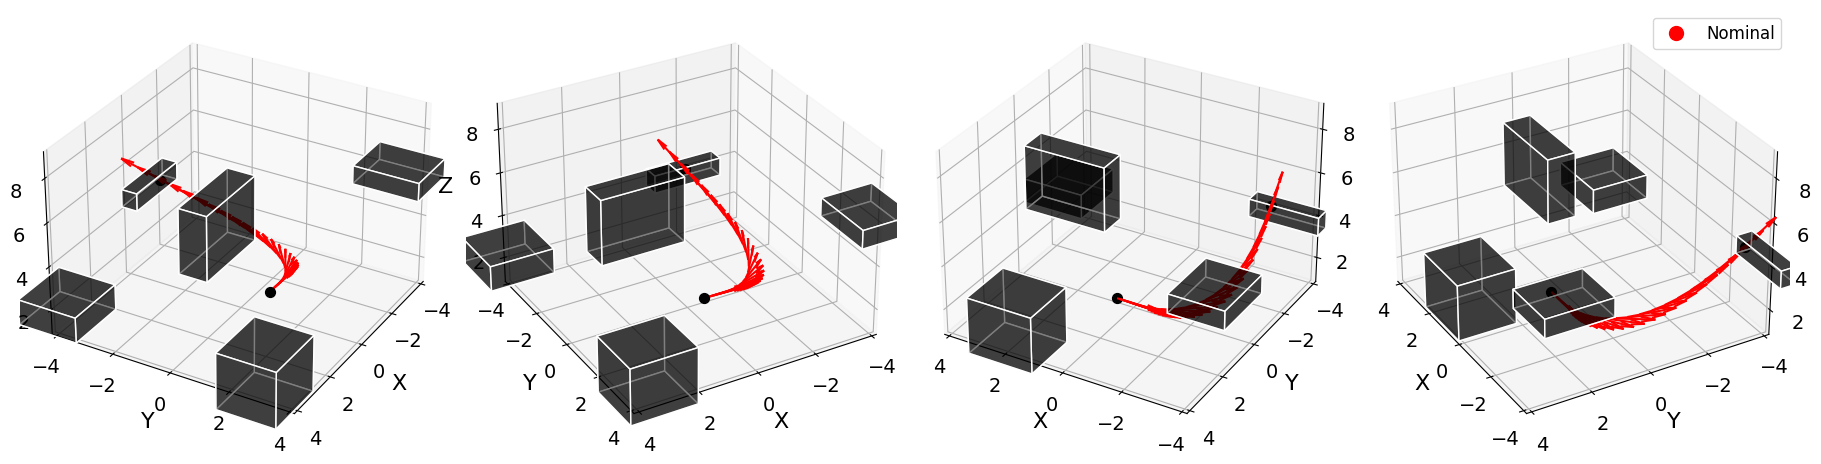

In [ ]:
#Unfiltered trajectory
initial_state = np.array([0, 1, 2, 0, 0, np.pi, 1])
T = 2.25
dt = 0.05
instance = F16_Controller(initial_state, dt, filter = None, alpha = .05)
trajectory = instance.calculate_trajectory(T)
instance.plot_trajectories([trajectory], ['Nominal'], ['r'])

In [ ]:
#Load Model
with open('F16_HJ_CBF01_IS.pkl', 'rb') as f:
    F16_HJ_CBF01_IS = dill.load(f)

In [ ]:
#Load Trajectories
with open('trajectory_NCBF', 'rb') as file:
    trajectory_NCBF = dill.load(file)
with open('trajectory_DeepReach', 'rb') as file:
    trajectory_DeepReach = dill.load(file)

In [ ]:
#Filtered trajectory
initial_state = np.array([0, 1, 2, 0, 0, np.pi, 1])
T = 3.0
dt = 0.05
instance1 = F16_Controller(initial_state, dt, filter = F16_HJ_CBF01_IS, alpha = .05)
trajectory_PINNCBF = instance1.calculate_trajectory(T)

In [ ]:
#Pad trajectories with last element until samle length, this isneeded because of collision

max_length = max(len(trajectory_PINNCBF), len(trajectory_DeepReach), len(trajectory_NCBF))

# Step 2: Pad each list
def pad_list(lst, target_length):
    last_element = lst[-1]  # Get the last element
    return lst + [last_element] * (target_length - len(lst))

trajectory_PINNCBF_padded = pad_list(trajectory_PINNCBF, max_length)
trajectory_DeepReach_padded = pad_list(trajectory_DeepReach, max_length)
trajectory_NCBF_padded = pad_list(trajectory_NCBF, max_length)

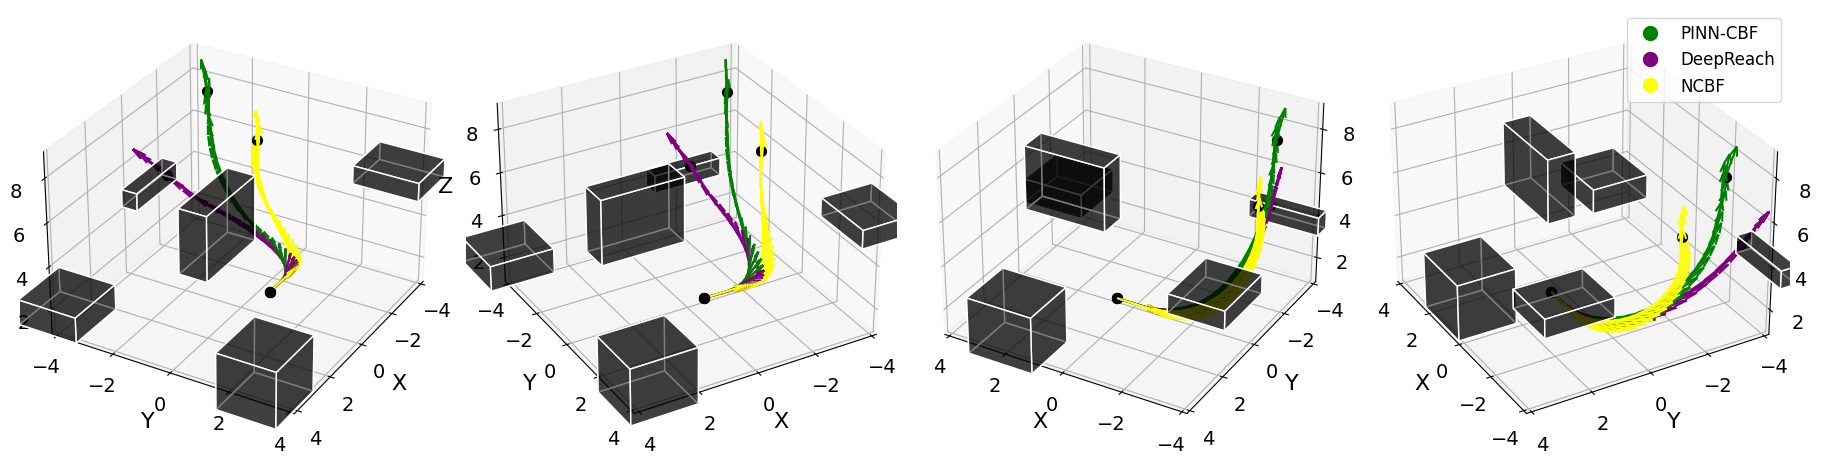

In [ ]:
#Plot the entire trajectories
instance1.plot_trajectories([trajectory_PINNCBF_padded, trajectory_DeepReach_padded, trajectory_NCBF_padded], ['PINN-CBF', 'DeepReach', 'NCBF'], ['green', 'purple', 'yellow'])

In [ ]:
def create_trajectory_video(state_trajectories, filename, trajectory_names=None, trajectory_colors=None, fps=24):
    """
    Creates a video animation of the trajectories with obstacles and rotates the camera.

    Args:
        state_trajectories (list): List of trajectories, each trajectory is a list of states.
        filename (str): The name of the output video file.
        trajectory_names (list): List of names for each trajectory.
        trajectory_colors (list): List of colors for each trajectory.
        fps (int): Frames per second for the output video.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Initialize the plot with axis limits
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(y_min - 1, y_max + 1)
    ax.set_zlim(z_min - 1, z_max + 1)

    # Function to update the plot for each frame
    def update_frame(frame_num):
        ax.clear()

        # Plot obstacles in every frame
        for obstacle in obstacles:
            s1, s2, s3, xc, yc, zc = obstacle
            vertices = np.array([[xc - s1 / 2, yc - s2 / 2, zc - s3 / 2],
                                 [xc + s1 / 2, yc - s2 / 2, zc - s3 / 2],
                                 [xc + s1 / 2, yc + s2 / 2, zc - s3 / 2],
                                 [xc - s1 / 2, yc + s2 / 2, zc - s3 / 2],
                                 [xc - s1 / 2, yc - s2 / 2, zc + s3 / 2],
                                 [xc + s1 / 2, yc - s2 / 2, zc + s3 / 2],
                                 [xc + s1 / 2, yc + s2 / 2, zc + s3 / 2],
                                 [xc - s1 / 2, yc + s2 / 2, zc + s3 / 2]])

            faces = [[vertices[j] for j in [0, 1, 2, 3]],
                     [vertices[j] for j in [4, 5, 6, 7]],
                     [vertices[j] for j in [0, 1, 5, 4]],
                     [vertices[j] for j in [2, 3, 7, 6]],
                     [vertices[j] for j in [0, 3, 7, 4]],
                     [vertices[j] for j in [1, 2, 6, 5]]]

            ax.add_collection3d(Poly3DCollection(faces, facecolors='black', linewidths=1, edgecolors='white', alpha=0.7))

        # Loop through each trajectory and plot up to the current frame
        for i, trajectory in enumerate(state_trajectories):
            positions = np.array(trajectory)

            x = positions[:frame_num, 0]
            y = positions[:frame_num, 1]
            z = positions[:frame_num, 2]

            # Set color for each trajectory
            color = trajectory_colors[i] if trajectory_colors is not None else 'blue'

            # Plot the trajectory
            ax.plot(x, y, z, color=color)

        # Plot the current points for all trajectories with labels
        for i, trajectory in enumerate(state_trajectories):
            current_position = trajectory[frame_num]
            color = trajectory_colors[i] if trajectory_colors is not None else 'blue'
            ax.scatter(current_position[0], current_position[1], current_position[2], color=color, s=100)

            # Display trajectory name if provided
            if trajectory_names is not None:
                ax.text(current_position[0], current_position[1], current_position[2],
                        trajectory_names[i], color=color, fontsize=12)

        # Rotate camera clockwise with respect to the Z-axis
        ax.view_init(elev=30, azim=frame_num * 2)  # Change 'azim' to rotate the view with each frame

        # Set axis labels and limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_zlim(z_min, z_max)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    # Number of frames is the length of the longest trajectory
    num_frames = max(len(traj) for traj in state_trajectories)

    # Create animation
    ani = animation.FuncAnimation(fig, update_frame, frames=num_frames, interval=1000 // fps)

    # Save the animation as a video file
    ani.save(filename, fps=fps, extra_args=['-vcodec', 'libx264'])

    plt.close(fig)
# def create_trajectory_video(state_trajectories, filename, trajectory_names=None, trajectory_colors=None, fps=10):
#     """
#     Creates a video animation of the trajectories with obstacles.

#     Args:
#         state_trajectories (list): List of trajectories, each trajectory is a list of states.
#         filename (str): The name of the output video file.
#         trajectory_names (list): List of names for each trajectory.
#         trajectory_colors (list): List of colors for each trajectory.
#         fps (int): Frames per second for the output video.
#     """
#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')

#     # Initialize the plot with axis limits
#     ax.set_xlim(x_min - 1, x_max + 1)
#     ax.set_ylim(y_min -1 , y_max + 1)
#     ax.set_zlim(z_min - 1, z_max + 1)

#     # Function to update the plot for each frame
#     def update_frame(frame_num):
#         ax.clear()

#         # Plot obstacles in every frame
#         for obstacle in obstacles:
#             s1, s2, s3, xc, yc, zc = obstacle
#             vertices = np.array([[xc - s1 / 2, yc - s2 / 2, zc - s3 / 2],
#                                  [xc + s1 / 2, yc - s2 / 2, zc - s3 / 2],
#                                  [xc + s1 / 2, yc + s2 / 2, zc - s3 / 2],
#                                  [xc - s1 / 2, yc + s2 / 2, zc - s3 / 2],
#                                  [xc - s1 / 2, yc - s2 / 2, zc + s3 / 2],
#                                  [xc + s1 / 2, yc - s2 / 2, zc + s3 / 2],
#                                  [xc + s1 / 2, yc + s2 / 2, zc + s3 / 2],
#                                  [xc - s1 / 2, yc + s2 / 2, zc + s3 / 2]])

#             faces = [[vertices[j] for j in [0, 1, 2, 3]],
#                      [vertices[j] for j in [4, 5, 6, 7]],
#                      [vertices[j] for j in [0, 1, 5, 4]],
#                      [vertices[j] for j in [2, 3, 7, 6]],
#                      [vertices[j] for j in [0, 3, 7, 4]],
#                      [vertices[j] for j in [1, 2, 6, 5]]]

#             ax.add_collection3d(Poly3DCollection(faces, facecolors='black', linewidths=1, edgecolors='white', alpha=0.7))

#         # Loop through each trajectory and plot up to the current frame
#         for i, trajectory in enumerate(state_trajectories):
#             positions = np.array(trajectory)

#             x = positions[:frame_num, 0]
#             y = positions[:frame_num, 1]
#             z = positions[:frame_num, 2]

#             # Set color for each trajectory
#             color = trajectory_colors[i] if trajectory_colors is not None else 'blue'

#             # Plot the trajectory
#             ax.plot(x, y, z, color=color)

#         # Plot the current points for all trajectories with labels
#         for i, trajectory in enumerate(state_trajectories):
#             current_position = trajectory[frame_num]
#             color = trajectory_colors[i] if trajectory_colors is not None else 'blue'
#             ax.scatter(current_position[0], current_position[1], current_position[2], color=color, s=100)

#             # Display trajectory name if provided
#             if trajectory_names is not None:
#                 ax.text(current_position[0], current_position[1], current_position[2],
#                         trajectory_names[i], color=color, fontsize=12)

#         # Set axis labels and limits
#         ax.set_xlim(x_min, x_max)
#         ax.set_ylim(y_min, y_max)
#         ax.set_zlim(z_min, z_max)
#         ax.set_xlabel('X')
#         ax.set_ylabel('Y')
#         ax.set_zlabel('Z')

#     # Number of frames is the length of the longest trajectory
#     num_frames = max(len(traj) for traj in state_trajectories)

#     # Create animation
#     ani = animation.FuncAnimation(fig, update_frame, frames=num_frames, interval=1000 // fps)

#     # Save the animation as a video file
#     ani.save(filename, fps=fps, extra_args=['-vcodec', 'libx264'])

#     plt.close(fig)

In [ ]:
#Create the video
state_trajectories = [
    np.array(trajectory_PINNCBF_padded)[:,0:3].tolist(),
    np.array(trajectory_DeepReach_padded)[:,0:3].tolist(),
    np.array(trajectory_NCBF_padded)[:,0:3].tolist()
]

create_trajectory_video(state_trajectories, 'trajectory_video.mp4', ['PINN-CBF', 'DeepReach', 'NCBF'], ['green', 'purple', 'yellow'])